In [1]:
import os
import glob
import json
import pandas as pd
import numpy as np

from itertools import groupby
from collections import Counter
from os.path import exists

In [2]:
def IssuerCode(state=False):
    issuers = pd.read_csv('data/list_of_issuer-20230322.csv',sep=';')
    issuer_filtered = []
    for code_stock in issuers.Code:
        # Check last transaction 2023
        # Have 200 transaction
        path = f'data/history/{code_stock}.csv'
        if os.path.exists(path):
            historical = pd.read_csv(path)
            last_date_row = historical.Date.iloc[len(historical)-1] # get last date transactions
            data_test = historical[len(historical)-(int(len(historical)*0.2)):]['Close'] # get data test
            var = np.var(data_test) # calculate variance from data test
            if (last_date_row[:4] == '2023' and len(historical) >= 200 and var > 0):
                issuer_filtered.append(code_stock)
    
    if state:
        print("Code of Stock Issuer: {}".format(issuer_filtered))
    else:
        return issuer_filtered

In [3]:
issuers = IssuerCode()

In [4]:
# read profile stock
def_sectors = ['Barang Baku','Barang Konsumen Non-Primer','Barang Konsumen Primer','Energi','Keuangan','Kesehatan','Perindustrian','Infrastruktur','Properti','Teknologi','Transportasi',]

undefined_sectors = ['PROPERTY, REAL ESTATE AND BUILDING CONSTRUCTION', 
                     'Transportasi & Logistik', 
                     'Financials', 
                     'MISCELLANEOUS INDUSTRY', 
                     'Consumer Cyclicals', 
                     'Properties & Real Estate', 
                     'INFRASTRUCTURE, UTILITIES  AND TRANSPORTATION', 
                     'BASIC INDUSTRY AND CHEMICALS', 
                     'TRADE, SERVICES & INVESTMENT', 
                     'CONSUMER GOODS INDUSTRY', 
                     'Properti & Real Estat']

path_profile = 'data/profile/'
path_transaction = 'data/history/'

issuer_sectors = {'code':[],'sector':[],'len':[]}

for issuer in issuers:
    filename = f'{path_profile}/{issuer}.json'
    profiles = json.load(open(filename))
    
    path = f'{path_transaction}{issuer}.csv'
    if exists(path):
        historical = pd.read_csv(path)
    
    if issuer in ['BOLT','RICY','INDS']:
        profiles['Profiles'][0]['Sektor'] = 'Barang Konsumen Non-Primer'
    elif issuer == 'IKBI':
        profiles['Profiles'][0]['Sektor'] = 'Perindustrian'    
    elif issuer == 'RIMO':
        profiles['Profiles'][0]['Sektor'] = 'Properti'
    elif profiles['Profiles'][0]['Sektor'] in undefined_sectors[:2]:
        profiles['Profiles'][0]['Sektor'] = 'Transportasi'
    elif profiles['Profiles'][0]['Sektor'] in undefined_sectors[2]:
        profiles['Profiles'][0]['Sektor'] = 'Keuangan'
    elif profiles['Profiles'][0]['Sektor'] in undefined_sectors[4]:
        profiles['Profiles'][0]['Sektor'] = 'Barang Konsumen Non-Primer'
    elif profiles['Profiles'][0]['Sektor'] in undefined_sectors[5]:
        profiles['Profiles'][0]['Sektor'] = 'Properti'
    elif profiles['Profiles'][0]['Sektor'] in undefined_sectors[6]:
        profiles['Profiles'][0]['Sektor'] = 'Transportasi'
    elif profiles['Profiles'][0]['Sektor'] in undefined_sectors[7]:
        profiles['Profiles'][0]['Sektor'] = 'Barang Baku'
    elif profiles['Profiles'][0]['Sektor'] in undefined_sectors[9]:
        profiles['Profiles'][0]['Sektor'] = 'Barang Konsumen Non-Primer'
    elif profiles['Profiles'][0]['Sektor'] in undefined_sectors[10]:
        profiles['Profiles'][0]['Sektor'] = 'Properti'
    
    if profiles['Profiles'][0]['Sektor'] not in undefined_sectors:
        issuer_sectors['code'].append(issuer)
        issuer_sectors['sector'].append(profiles['Profiles'][0]['Sektor'])
        issuer_sectors['len'].append(len(historical))
    else:
        print(profiles['Profiles'][0]['Sektor'])

# sectors = sorted(list(set(issuer_sectors['sector'])))
# print(sectors)
# print(len(issuer_sectors['code']))

In [5]:
# Sort the data by the 'sector' key
sorted_data = sorted(zip(issuer_sectors['sector'], issuer_sectors['code']))

# Group the data by the 'sector' key
grouped_data = groupby(sorted_data, key=lambda x: x[0])

# Create a new dictionary to store the grouped data
grouped_sectors = {}

# Iterate over the grouped data and store it in the new dictionary
for sector, group in grouped_data:
    codes = [item[1] for item in group]
    grouped_sectors[sector] = codes

print(grouped_sectors)

{'Barang Baku': ['ADMG', 'AGII', 'AKPI', 'ALDO', 'ALKA', 'ALMI', 'ANTM', 'APLI', 'ARCI', 'AVIA', 'AYLS', 'BAJA', 'BEBS', 'BMSR', 'BRMS', 'BRNA', 'BRPT', 'BTON', 'CITA', 'CLPI', 'CMNT', 'CTBN', 'DKFT', 'DPNS', 'EKAD', 'ESIP', 'ESSA', 'FASW', 'FPNI', 'GDST', 'GGRP', 'IFII', 'IFSH', 'IGAR', 'INAI', 'INCF', 'INCI', 'INCO', 'INKP', 'INRU', 'INTD', 'INTP', 'IPOL', 'ISSP', 'JKSW', 'KAYU', 'KDSI', 'KMTR', 'KRAS', 'LMSH', 'LTLS', 'MDKA', 'MDKI', 'MOLI', 'NICL', 'NIKL', 'NPGF', 'OBMD', 'OKAS', 'OPMS', 'PBID', 'PICO', 'PNGO', 'PSAB', 'PURE', 'SAMF', 'SBMA', 'SIMA', 'SMBR', 'SMCB', 'SMGR', 'SMKL', 'SPMA', 'SQMI', 'SRSN', 'SULI', 'SWAT', 'TALF', 'TBMS', 'TINS', 'TIRT', 'TKIM', 'TPIA', 'TRST', 'UNIC', 'WSBP', 'WTON', 'YPAS', 'ZINC'], 'Barang Konsumen Non-Primer': ['ABBA', 'ACES', 'AKKU', 'ARGO', 'ARTA', 'ASLC', 'AUTO', 'BATA', 'BAYU', 'BELL', 'BIKE', 'BIMA', 'BLTZ', 'BOGA', 'BOLA', 'BOLT', 'BRAM', 'BUVA', 'CARS', 'CBMF', 'CINT', 'CLAY', 'CNTX', 'CSAP', 'DEPO', 'DFAM', 'DIGI', 'DRMA', 'EAST', 'ECII',

In [6]:
sector_counts = Counter(issuer_sectors['sector'])
print(sector_counts)

Counter({'Barang Konsumen Non-Primer': 121, 'Keuangan': 103, 'Barang Konsumen Primer': 97, 'Barang Baku': 89, 'Properti': 69, 'Energi': 67, 'Infrastruktur': 52, 'Perindustrian': 51, 'Teknologi': 29, 'Transportasi': 25, 'Kesehatan': 24})


In [7]:
sum_by_sector = {}
sector_counter = Counter()

for code, sector, length in zip(issuer_sectors['code'], issuer_sectors['sector'], issuer_sectors['len']):
    if sector not in sum_by_sector:
        sum_by_sector[sector] = 0
    sum_by_sector[sector] += length
    sector_counter[sector] += 1

print(dict(sorted(sum_by_sector.items())))
print(dict(sorted(sector_counter.items())))


{'Barang Baku': 308749, 'Barang Konsumen Non-Primer': 362480, 'Barang Konsumen Primer': 283436, 'Energi': 195815, 'Infrastruktur': 133130, 'Kesehatan': 61862, 'Keuangan': 364663, 'Perindustrian': 171737, 'Properti': 209202, 'Teknologi': 43319, 'Transportasi': 60955}
{'Barang Baku': 89, 'Barang Konsumen Non-Primer': 121, 'Barang Konsumen Primer': 97, 'Energi': 67, 'Infrastruktur': 52, 'Kesehatan': 24, 'Keuangan': 103, 'Perindustrian': 51, 'Properti': 69, 'Teknologi': 29, 'Transportasi': 25}


In [9]:
issuer_result = {'code':[],'sector':[],'lookback':[],'arch':[],'r2':[],'mse':[],'rmse':[],'mape':[],'acc':[],'f1':[]}

lookbacks = [5,10,15,20,25]
architecture = ['TFCNN','TFCNNGRU','TFCNNLSTM','TFGRU','TFGRUCNN','TFGRULSTM','TFLSTM','TFLSTMCNN','TFLSTMGRU','TFGCNGRU','TFGCNLSTM']

path_result = 'results/evaluations/'

for code, sector in zip(issuer_sectors['code'], issuer_sectors['sector']):
    for archi in architecture:
        for lookback in lookbacks:
            if 'GCN' in archi:
                path_score = f'{path_result}{archi}_multivariate_graph/{code}_{lookback}_test_score.json'
                path_class = f'{path_result}{archi}_multivariate_graph/{code}_{lookback}_test_classification.json'
            else:
                path_score = f'{path_result}{archi}_multivariate/{code}_{lookback}_test_score.json'
                path_class = f'{path_result}{archi}_multivariate/{code}_{lookback}_test_classification.json'
            
            score_json = json.load(open(path_score))
            class_json = json.load(open(path_class))
            
            issuer_result['code'].append(code)
            issuer_result['sector'].append(sector)
            issuer_result['lookback'].append(lookback)
            issuer_result['arch'].append(archi)
            issuer_result['r2'].append(score_json['R2'])
            issuer_result['mse'].append(score_json['MSE'])
            issuer_result['rmse'].append(score_json['RMSE'])
            issuer_result['mape'].append(score_json['MAPE'])
            issuer_result['acc'].append(class_json['accuracy'])
            issuer_result['f1'].append(class_json['macro avg']['f1-score'] if 'macro avg' in class_json else 0)
            

In [10]:
df_result = pd.DataFrame(issuer_result)
df_averages = df_result.groupby(['code', 'sector', 'arch'], as_index=False).mean()[['code', 'sector', 'arch', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']]

best_arch_r2 = df_averages.loc[df_averages.groupby(['code', 'sector'])['r2'].idxmax()]
best_arch_mse = df_averages.loc[df_averages.groupby(['code', 'sector'])['mse'].idxmin()]
best_arch_rmse = df_averages.loc[df_averages.groupby(['code', 'sector'])['rmse'].idxmin()]
best_arch_mape = df_averages.loc[df_averages.groupby(['code', 'sector'])['mape'].idxmin()]
best_arch_f1 = df_averages.loc[df_averages.groupby(['code', 'sector'])['f1'].idxmax()]

df_best = pd.concat([best_arch_r2, best_arch_mse, best_arch_rmse, best_arch_mape, best_arch_f1])

df_best_arch = df_best.groupby(['code', 'sector', 'arch'], as_index=False).count()[['code', 'sector', 'arch', 'r2']]
best_arch = df_best_arch.loc[df_best_arch.groupby(['code', 'sector'])['r2'].idxmax()]
best_arch = best_arch.rename(columns={'r2': 'count'})
best_arch_count = best_arch.groupby(['arch'], as_index=False).count()[['arch','count']]

         arch  count
1    TFCNNGRU      3
2   TFCNNLSTM      4
3    TFGCNGRU      5
4   TFGCNLSTM      6
9   TFLSTMCNN      6
6    TFGRUCNN      7
8      TFLSTM     50
0       TFCNN     85
10  TFLSTMGRU     98
7   TFGRULSTM    148
5       TFGRU    315


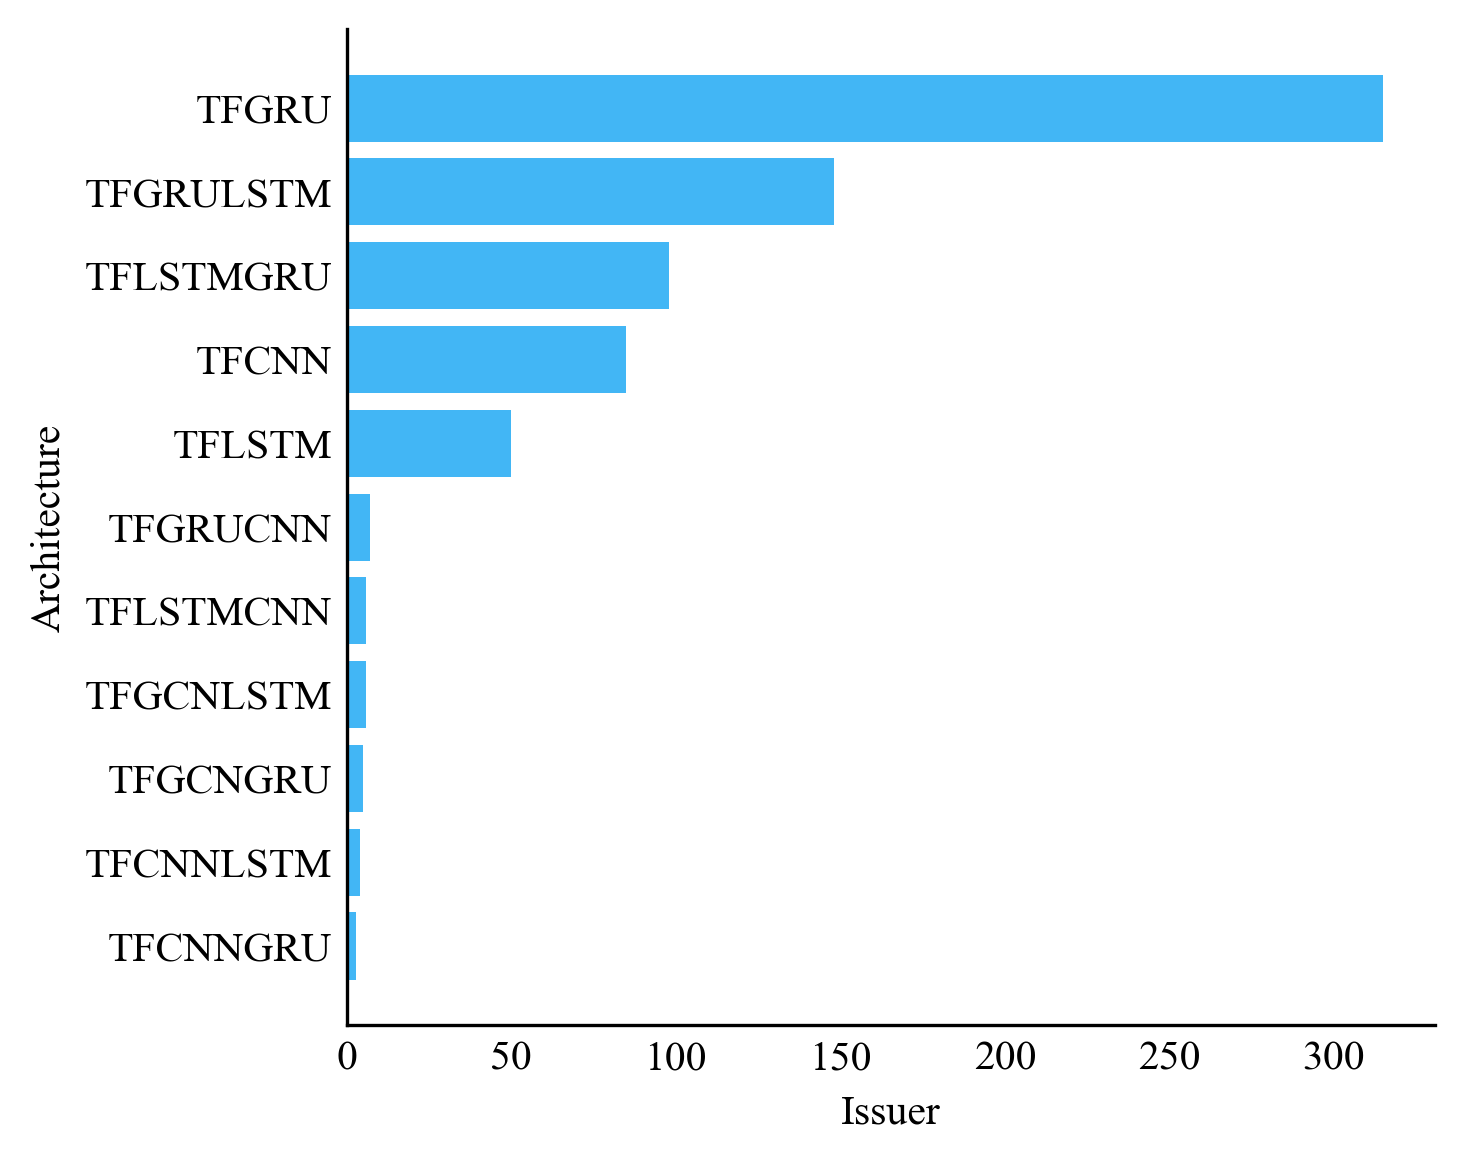

In [11]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

# bar_colors = ['#4287f5', '#42f5a3', '#f54242', '#f5d142', '#a342f5', '#f57f42', '#42b6f5', '#f542c6', '#42f5e9', '#c6f542', '#f5bc42']
df = best_arch_count.sort_values('count', ascending=True)
print(df)
plt.barh(df['arch'], df['count'], color='#42b6f5')
plt.xlabel('Issuer')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

In [12]:
df_result = pd.DataFrame(issuer_result)
df_averages_score = df_result.groupby(['arch'], as_index=False).mean()[['arch', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']]
df_averages_score.to_excel('df_averages_score.xlsx', index=False)

         arch         r2           mse          rmse       mape       acc  \
1    TFCNNGRU -89.623446  3.007883e+08    798.240294   1.592150  0.506090   
0       TFCNN -75.412739  2.673750e+08    719.959398   1.267574  0.496847   
2   TFCNNLSTM -64.570786  6.065765e+08   1084.489438   2.800634  0.499901   
9   TFLSTMCNN -57.022000  5.327556e+08    995.027146   2.375053  0.500070   
6    TFGRUCNN -44.098616  4.931480e+08    977.244839   2.339197  0.499846   
3    TFGCNGRU -42.694786  1.265779e+11  13219.663638  42.936618  0.506753   
5       TFGRU -40.130348  1.279781e+08    553.327685   0.858993  0.516934   
10  TFLSTMGRU -38.045735  1.928364e+08    662.084217   1.345837  0.515080   
7   TFGRULSTM -36.019696  1.795644e+08    651.552776   1.327186  0.512021   
8      TFLSTM -33.011495  1.776545e+08    638.082995   1.292215  0.517473   
4   TFGCNLSTM -29.200573  2.839899e+10   6362.068805  19.891115  0.503327   

          f1  
1   0.465833  
0   0.464655  
2   0.458964  
9   0.445180  


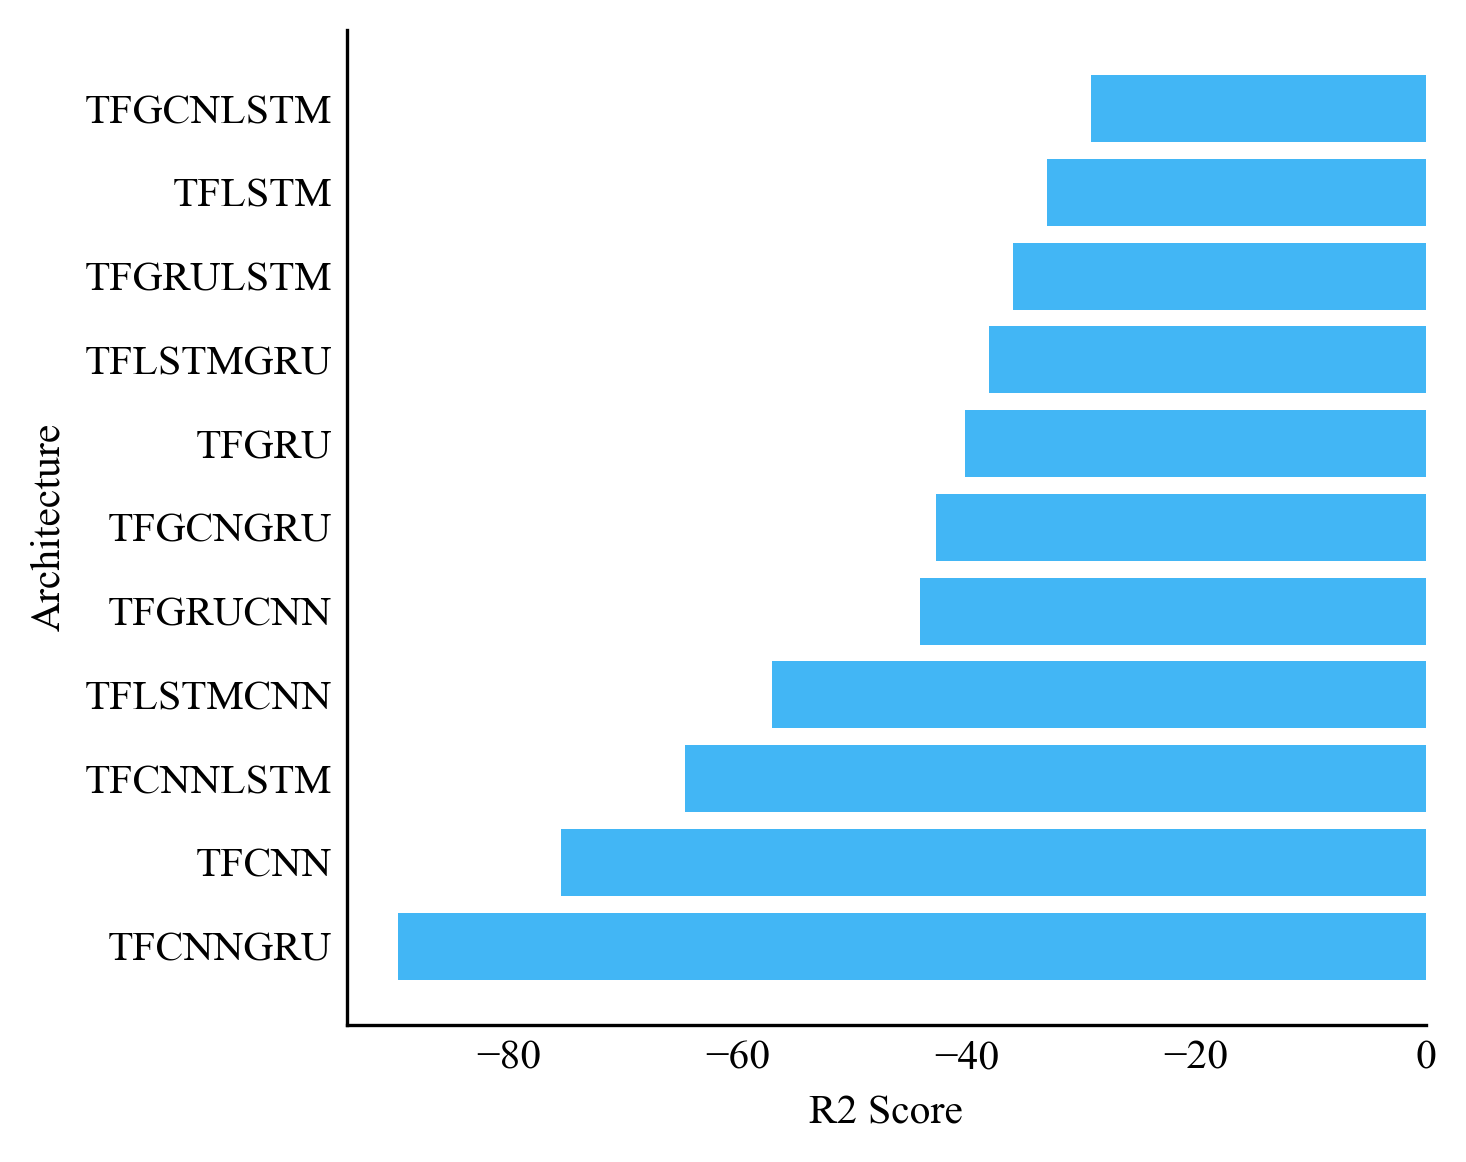

In [13]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('r2', ascending=True)
print(df)
plt.barh(df['arch'], df['r2'], color='#42b6f5')
plt.xlabel('R2 Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

         arch         r2           mse          rmse       mape       acc  \
3    TFGCNGRU -42.694786  1.265779e+11  13219.663638  42.936618  0.506753   
4   TFGCNLSTM -29.200573  2.839899e+10   6362.068805  19.891115  0.503327   
2   TFCNNLSTM -64.570786  6.065765e+08   1084.489438   2.800634  0.499901   
9   TFLSTMCNN -57.022000  5.327556e+08    995.027146   2.375053  0.500070   
6    TFGRUCNN -44.098616  4.931480e+08    977.244839   2.339197  0.499846   
1    TFCNNGRU -89.623446  3.007883e+08    798.240294   1.592150  0.506090   
0       TFCNN -75.412739  2.673750e+08    719.959398   1.267574  0.496847   
10  TFLSTMGRU -38.045735  1.928364e+08    662.084217   1.345837  0.515080   
7   TFGRULSTM -36.019696  1.795644e+08    651.552776   1.327186  0.512021   
8      TFLSTM -33.011495  1.776545e+08    638.082995   1.292215  0.517473   
5       TFGRU -40.130348  1.279781e+08    553.327685   0.858993  0.516934   

          f1  
3   0.457040  
4   0.449355  
2   0.458964  
9   0.445180  


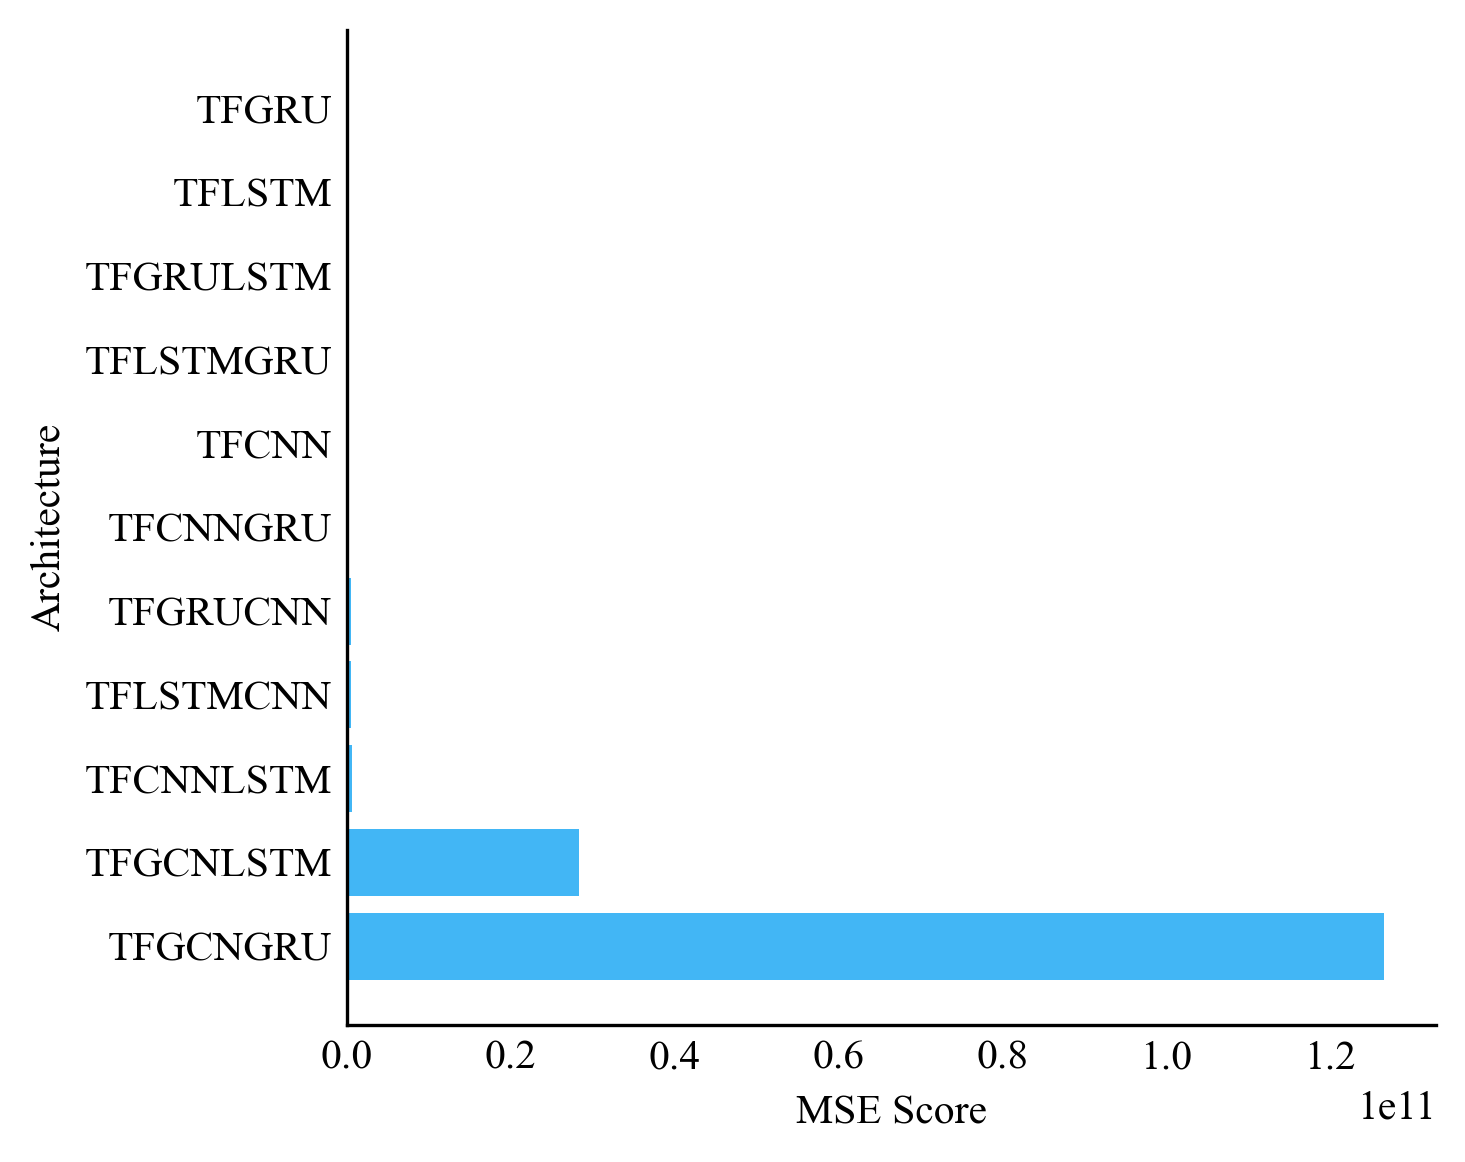

In [14]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('mse', ascending=False)
print(df)
plt.barh(df['arch'], df['mse'], color='#42b6f5')
plt.xlabel('MSE Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

         arch         r2           mse          rmse       mape       acc  \
3    TFGCNGRU -42.694786  1.265779e+11  13219.663638  42.936618  0.506753   
4   TFGCNLSTM -29.200573  2.839899e+10   6362.068805  19.891115  0.503327   
2   TFCNNLSTM -64.570786  6.065765e+08   1084.489438   2.800634  0.499901   
9   TFLSTMCNN -57.022000  5.327556e+08    995.027146   2.375053  0.500070   
6    TFGRUCNN -44.098616  4.931480e+08    977.244839   2.339197  0.499846   
1    TFCNNGRU -89.623446  3.007883e+08    798.240294   1.592150  0.506090   
0       TFCNN -75.412739  2.673750e+08    719.959398   1.267574  0.496847   
10  TFLSTMGRU -38.045735  1.928364e+08    662.084217   1.345837  0.515080   
7   TFGRULSTM -36.019696  1.795644e+08    651.552776   1.327186  0.512021   
8      TFLSTM -33.011495  1.776545e+08    638.082995   1.292215  0.517473   
5       TFGRU -40.130348  1.279781e+08    553.327685   0.858993  0.516934   

          f1  
3   0.457040  
4   0.449355  
2   0.458964  
9   0.445180  


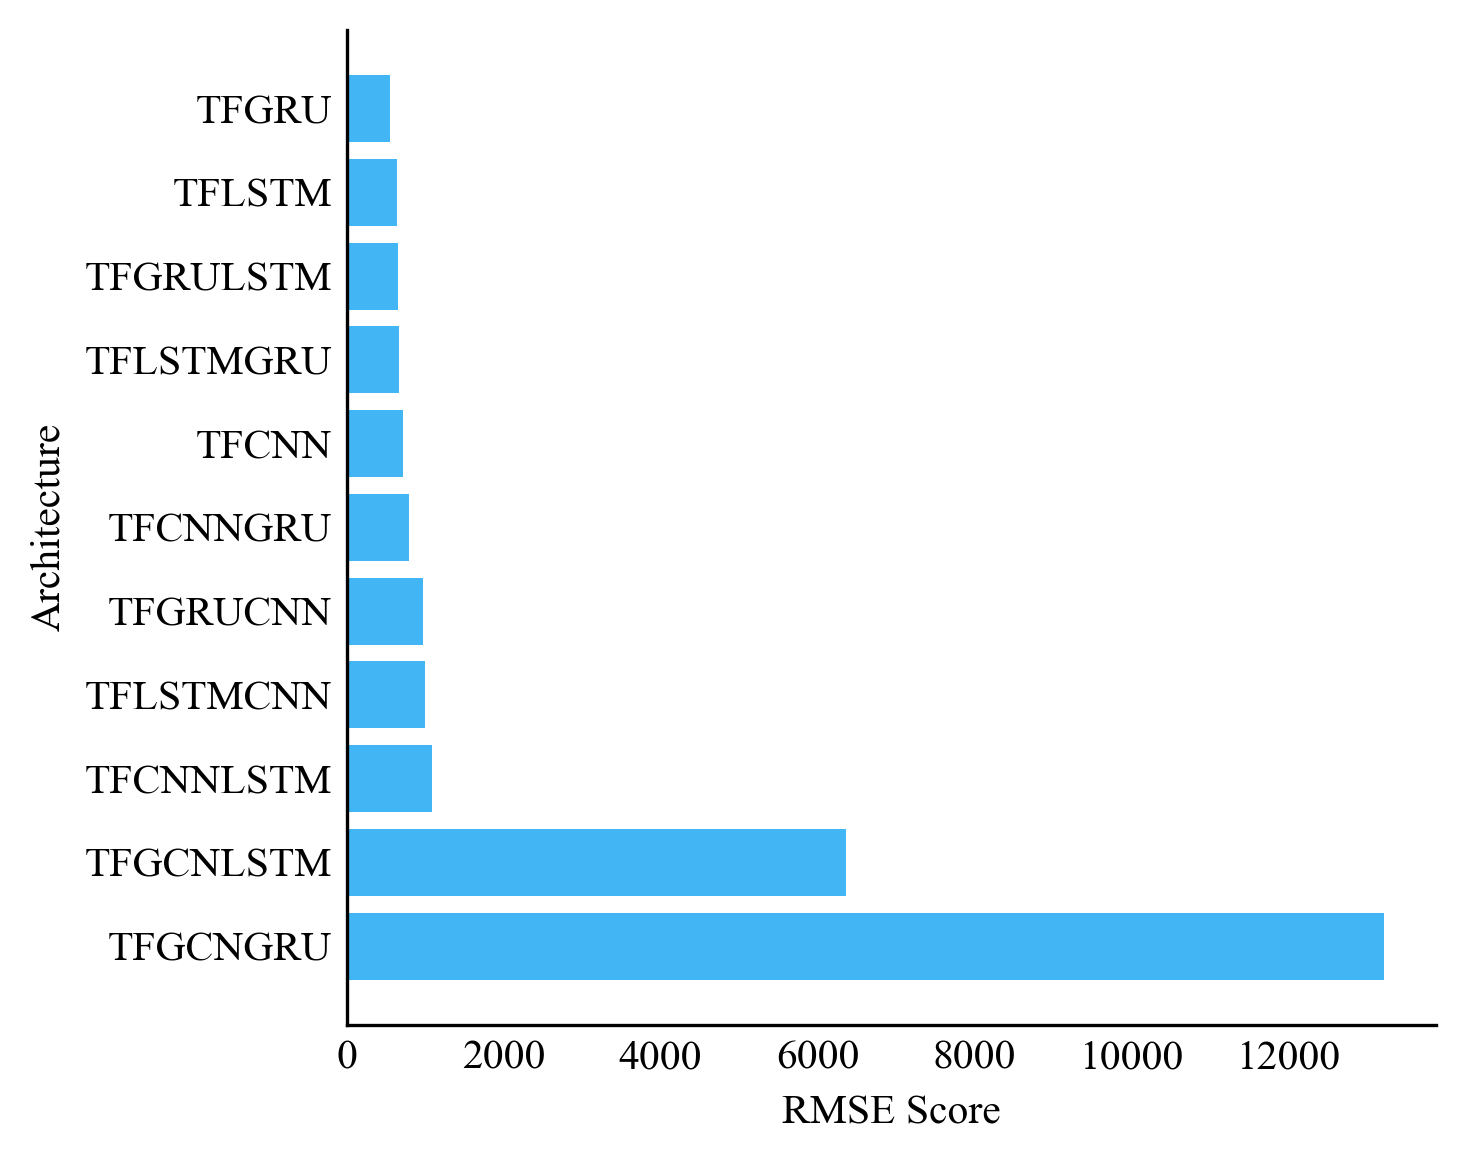

In [15]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('rmse', ascending=False)
print(df)
plt.barh(df['arch'], df['rmse'], color='#42b6f5')
plt.xlabel('RMSE Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

         arch         r2           mse          rmse       mape       acc  \
3    TFGCNGRU -42.694786  1.265779e+11  13219.663638  42.936618  0.506753   
4   TFGCNLSTM -29.200573  2.839899e+10   6362.068805  19.891115  0.503327   
2   TFCNNLSTM -64.570786  6.065765e+08   1084.489438   2.800634  0.499901   
9   TFLSTMCNN -57.022000  5.327556e+08    995.027146   2.375053  0.500070   
6    TFGRUCNN -44.098616  4.931480e+08    977.244839   2.339197  0.499846   
1    TFCNNGRU -89.623446  3.007883e+08    798.240294   1.592150  0.506090   
10  TFLSTMGRU -38.045735  1.928364e+08    662.084217   1.345837  0.515080   
7   TFGRULSTM -36.019696  1.795644e+08    651.552776   1.327186  0.512021   
8      TFLSTM -33.011495  1.776545e+08    638.082995   1.292215  0.517473   
0       TFCNN -75.412739  2.673750e+08    719.959398   1.267574  0.496847   
5       TFGRU -40.130348  1.279781e+08    553.327685   0.858993  0.516934   

          f1  
3   0.457040  
4   0.449355  
2   0.458964  
9   0.445180  


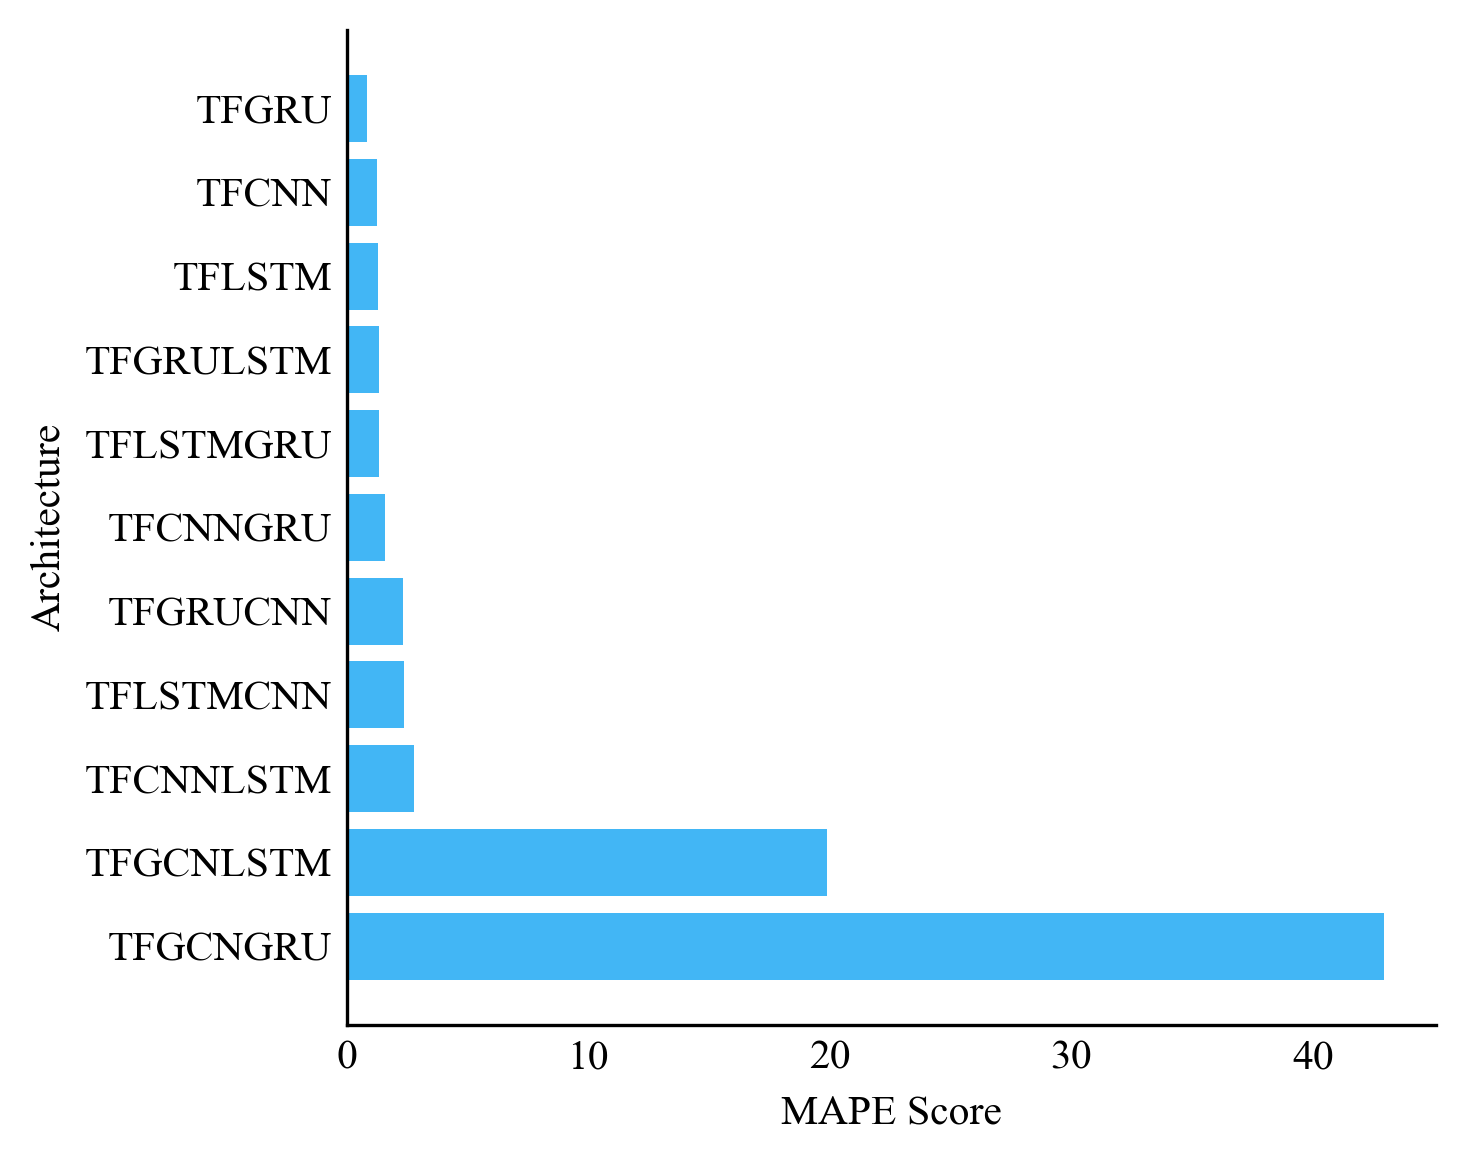

In [16]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('mape', ascending=False)
print(df)
plt.barh(df['arch'], df['mape'], color='#42b6f5')
plt.xlabel('MAPE Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

         arch         r2           mse          rmse       mape       acc  \
6    TFGRUCNN -44.098616  4.931480e+08    977.244839   2.339197  0.499846   
9   TFLSTMCNN -57.022000  5.327556e+08    995.027146   2.375053  0.500070   
4   TFGCNLSTM -29.200573  2.839899e+10   6362.068805  19.891115  0.503327   
5       TFGRU -40.130348  1.279781e+08    553.327685   0.858993  0.516934   
3    TFGCNGRU -42.694786  1.265779e+11  13219.663638  42.936618  0.506753   
2   TFCNNLSTM -64.570786  6.065765e+08   1084.489438   2.800634  0.499901   
7   TFGRULSTM -36.019696  1.795644e+08    651.552776   1.327186  0.512021   
10  TFLSTMGRU -38.045735  1.928364e+08    662.084217   1.345837  0.515080   
8      TFLSTM -33.011495  1.776545e+08    638.082995   1.292215  0.517473   
0       TFCNN -75.412739  2.673750e+08    719.959398   1.267574  0.496847   
1    TFCNNGRU -89.623446  3.007883e+08    798.240294   1.592150  0.506090   

          f1  
6   0.443013  
9   0.445180  
4   0.449355  
5   0.456721  


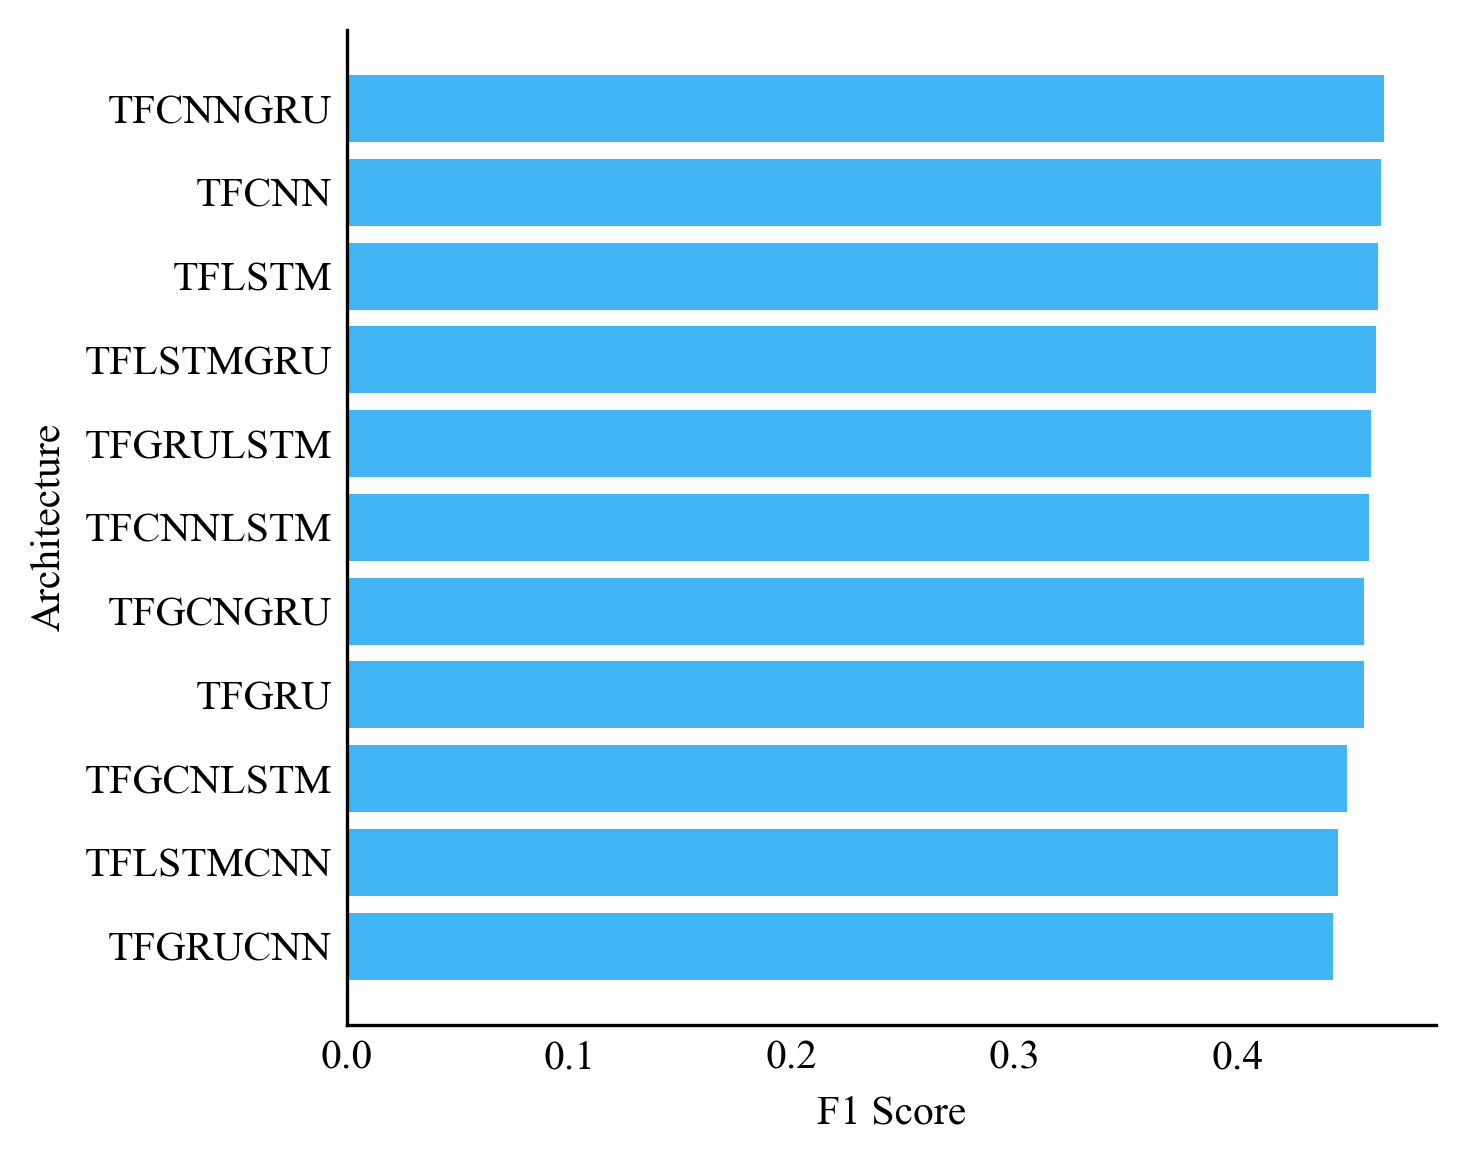

In [17]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('f1', ascending=True)
print(df)
plt.barh(df['arch'], df['f1'], color='#42b6f5')
plt.xlabel('F1 Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

In [19]:
df_result_sort = df_result.sort_values(by=['f1', 'acc', 'mape', 'rmse', 'mse', 'r2'], ascending=[False, False, True, True, True, False])
print(df_result_sort)
# df_result_sort.to_excel('df_result_sort.xlsx', index=False)

       code                      sector  lookback       arch        r2  \
17176  SRIL  Barang Konsumen Non-Primer        10      TFGRU  0.507671   
17175  SRIL  Barang Konsumen Non-Primer         5      TFGRU -0.426293   
500    NANO      Barang Konsumen Primer         5   TFCNNGRU  0.132910   
17190  SRIL  Barang Konsumen Non-Primer         5     TFLSTM  0.294858   
29585  JKSW                 Barang Baku         5  TFGCNLSTM  0.166069   
...     ...                         ...       ...        ...       ...   
37548  BLTA                Transportasi        20  TFLSTMCNN -0.423144   
37555  BLTA                Transportasi         5   TFGCNGRU -0.547597   
37562  BLTA                Transportasi        15  TFGCNLSTM -1.459551   
37563  BLTA                Transportasi        20  TFGCNLSTM -2.052551   
37564  BLTA                Transportasi        25  TFGCNLSTM -2.949554   

               mse       rmse      mape       acc        f1  
17176    17.807300   4.219870  0.028169  0.987578